# Q-learning 强化学习算法

## 什么是Q-learning？

Q-learning是一种无模型(model-free)的强化学习算法，它通过学习动作价值函数(Q函数)来找到最优策略。

### 核心概念

1. **Q值(Q-value)**: 表示在某个状态下采取某个动作的价值，记作Q(s,a)
2. **Q表(Q-table)**: 存储所有状态-动作对的Q值
3. **探索与利用**: 在探索新动作和利用已知最优动作之间找到平衡

### Q-learning更新公式

Q(s,a) ← Q(s,a) + α[r + γ * max Q(s',a') - Q(s,a)]

其中：
- α: 学习率(0 < α ≤ 1)
- γ: 折扣因子(0 ≤ γ < 1)
- r: 即时奖励
- s': 下一个状态
- a': 下一个动作

### 公式详细解释

让我们深入理解Q-learning更新公式的每个组成部分：

#### 1. 当前Q值 Q(s,a)
- **含义**：表示在状态s下采取动作a的当前估计价值
- **初始化**：通常设为0或小的随机值
- **更新过程**：随着学习过程逐步优化

#### 2. 学习率 α (0 < α ≤ 1)
- **核心作用**：控制学习的步长大小
- **极端情况**：
  - α = 1：完全用新估计值替换旧值（激进学习）
  - α → 0：学习缓慢，几乎保留旧知识（保守学习）
- **推荐设置**：通常设置为0.1-0.3之间

#### 3. 即时奖励 r
- **来源**：执行动作a后环境返回的立即奖励
- **性质**：可以是正数（鼓励行为）或负数（惩罚行为）
- **示例**：在迷宫环境中，到达目标+10，掉入陷阱-10，普通移动-1

#### 4. 折扣因子 γ (0 ≤ γ < 1)
- **核心作用**：权衡即时奖励和未来奖励的重要性
- **极端情况**：
  - γ = 0：完全短视，只考虑即时奖励
  - γ → 1：有远见，重视长期累积奖励
- **推荐设置**：通常设置为0.8-0.99之间

#### 5. 最大未来Q值 max Q(s',a')
- **含义**：在新状态s'下，所有可能动作中的最大Q值
- **作用**：表示从s'状态开始能获得的最佳长期价值
- **本质**：体现了"最优未来价值"的概念

#### 6. 时序差分误差 (TD Error)
**TD Error = [r + γ * max Q(s',a')] - Q(s,a)**

- **本质**：当前估计与目标估计之间的差异
- **误差分析**：
  - 正误差：当前估计偏低，需要增加Q值
  - 负误差：当前估计偏高，需要减少Q值
  - 零误差：当前估计准确，无需调整

#### 7. 公式的直观理解
```
新Q值 = 旧Q值 + 学习率 × (目标值 - 旧Q值)
      = 旧Q值 + 学习率 × TD误差
```

这个更新过程类似于**梯度下降算法**，通过迭代优化逐步减小估计误差，最终使Q值收敛到真实的最优动作价值。

## Q-learning算法流程

1. 初始化Q表为0或随机值
2. 对于每个episode:
   - 初始化状态s
   - 对于每个时间步:
     - 根据ε-贪心策略选择动作a
     - 执行动作a，观察奖励r和新状态s'
     - 更新Q值: Q(s,a) ← Q(s,a) + α[r + γ * max Q(s',a') - Q(s,a)]
     - s ← s'
   - 直到达到终止状态

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns

# 设置随机种子
np.random.seed(42)
random.seed(42)

## 1. 迷宫环境定义

我们创建一个简单的迷宫环境来演示Q-learning算法。

环境描述：
- 4x4网格世界
- 起点：左上角(0,0)
- 终点：右下角(3,3)
- 陷阱：(1,1)和(2,2)
- 动作：上、下、左、右
- 奖励：到达终点+10，掉入陷阱-10，其他位置-1

In [2]:
class MazeEnv:
    def __init__(self):
        self.rows = 4
        self.cols = 4
        self.start_state = (0, 0)
        self.goal_state = (3, 3)
        self.trap_states = [(1, 1), (2, 2)]
        self.actions = ['up', 'down', 'left', 'right']
        
    def reset(self):
        """重置环境到初始状态"""
        self.current_state = self.start_state
        return self.current_state
    
    def step(self, action):
        """执行动作并返回(新状态, 奖励, 是否结束)"""
        row, col = self.current_state
        
        # 根据动作更新位置
        if action == 'up' and row > 0:
            row -= 1
        elif action == 'down' and row < self.rows - 1:
            row += 1
        elif action == 'left' and col > 0:
            col -= 1
        elif action == 'right' and col < self.cols - 1:
            col += 1
        
        self.current_state = (row, col)
        
        # 计算奖励
        if self.current_state == self.goal_state:
            reward = 10
            done = True
        elif self.current_state in self.trap_states:
            reward = -10
            done = True
        else:
            reward = -1
            done = False
            
        return self.current_state, reward, done

## 2. Q-learning算法实现

In [3]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        
        # 初始化Q表
        self.q_table = defaultdict(lambda: defaultdict(float))
        
    def get_action(self, state):
        """ε-贪心策略选择动作"""
        if random.random() < self.epsilon:
            # 探索：随机选择动作
            return random.choice(self.env.actions)
        else:
            # 利用：选择Q值最大的动作
            q_values = self.q_table[state]
            if not q_values:
                return random.choice(self.env.actions)
            max_q = max(q_values.values())
            best_actions = [a for a, q in q_values.items() if q == max_q]
            return random.choice(best_actions)
    
    def update_q_value(self, state, action, reward, next_state):
        """更新Q值"""
        # 计算当前Q值
        current_q = self.q_table[state][action]
        
        # 计算下一个状态的最大Q值
        next_q_values = self.q_table[next_state]
        max_next_q = max(next_q_values.values()) if next_q_values else 0
        
        # Q-learning更新公式
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )
        
        self.q_table[state][action] = new_q
    
    def train(self, episodes=1000):
        """训练Q-learning智能体"""
        rewards_per_episode = []
        
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            
            while not done and steps < 100:  # 限制最大步数
                action = self.get_action(state)
                next_state, reward, done = self.env.step(action)
                
                self.update_q_value(state, action, reward, next_state)
                
                state = next_state
                total_reward += reward
                steps += 1
            
            rewards_per_episode.append(total_reward)
            
            # 每100个episode打印一次进度
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(rewards_per_episode[-100:])
                print(f"Episode {episode + 1}, Average Reward (last 100): {avg_reward:.2f}")
        
        return rewards_per_episode
    
    def get_optimal_policy(self):
        """获取最优策略"""
        policy = {}
        for row in range(self.env.rows):
            for col in range(self.env.cols):
                state = (row, col)
                q_values = self.q_table[state]
                if q_values:
                    best_action = max(q_values, key=q_values.get)
                    policy[state] = best_action
                else:
                    policy[state] = random.choice(self.env.actions)
        return policy
    
    def print_q_table(self):
        """打印Q表"""
        print("Q-table:")
        for state in sorted(self.q_table.keys()):
            print(f"State {state}:")
            for action, q_value in self.q_table[state].items():
                print(f"  {action}: {q_value:.2f}")

## 3. 训练Q-learning智能体

In [4]:
# 创建环境和智能体
env = MazeEnv()
agent = QLearningAgent(env, learning_rate=0.1, discount_factor=0.9, epsilon=0.1)

# 训练智能体
print("开始训练Q-learning智能体...")
rewards = agent.train(episodes=1000)

# 打印最终的Q表
agent.print_q_table()

# 打印最优策略
optimal_policy = agent.get_optimal_policy()
print("\n最优策略:")
for row in range(env.rows):
    for col in range(env.cols):
        state = (row, col)
        action = optimal_policy[state]
        print(f"{state}: {action}")

开始训练Q-learning智能体...
Episode 100, Average Reward (last 100): -4.37
Episode 200, Average Reward (last 100): 2.25
Episode 300, Average Reward (last 100): 2.31
Episode 400, Average Reward (last 100): 2.09
Episode 500, Average Reward (last 100): 2.50
Episode 600, Average Reward (last 100): 2.49
Episode 700, Average Reward (last 100): 2.13
Episode 800, Average Reward (last 100): 2.37
Episode 900, Average Reward (last 100): 2.75
Episode 1000, Average Reward (last 100): 2.20
Q-table:
State (0, 0):
  up: 0.06
  down: 1.81
  left: 0.34
  right: -9.56
State (0, 1):
  down: -9.92
State (1, 0):
  up: 0.12
  right: -9.58
  down: 3.12
  left: 1.32
State (1, 1):
State (2, 0):
  right: 4.58
  left: 2.89
  down: 2.51
  up: 1.64
State (2, 1):
  down: 6.20
  right: -9.58
  left: 2.84
  up: -9.02
State (2, 2):
State (3, 0):
  left: -0.20
  down: -0.20
  up: 0.32
  right: 6.03
State (3, 1):
  right: 8.00
  down: 5.62
  left: 3.30
  up: 4.30
State (3, 2):
  right: 10.00
  up: -8.78
  left: 5.42
  down: 7.48

## 4. 可视化训练结果

/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/3711826473.py:18: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/3711826473.py:18: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/3711826473.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/3711826473.py:18: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/3711826473.py:18: UserWarning: Glyph 21169 (\N{CJK UNIFIED IDEOGRAPH-52B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgch

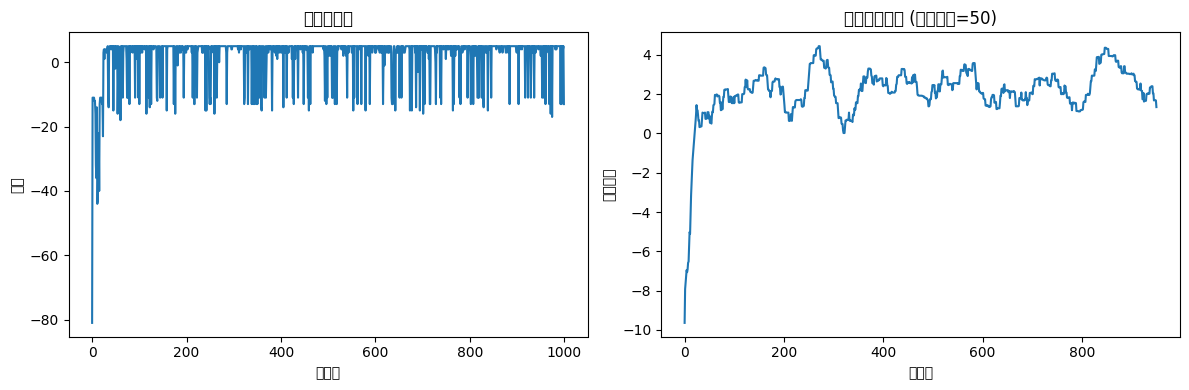

In [5]:
# 绘制奖励曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('每回合奖励')
plt.xlabel('回合数')
plt.ylabel('奖励')

plt.subplot(1, 2, 2)
window_size = 50
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title(f'移动平均奖励 (窗口大小={window_size})')
plt.xlabel('回合数')
plt.ylabel('平均奖励')

plt.tight_layout()
plt.show()

## 5. 可视化Q值热力图

/Users/liuyanan.166/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/liuyanan.166/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/liuyanan.166/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/liuyanan.166/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/liuyanan.166/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/liuyanan

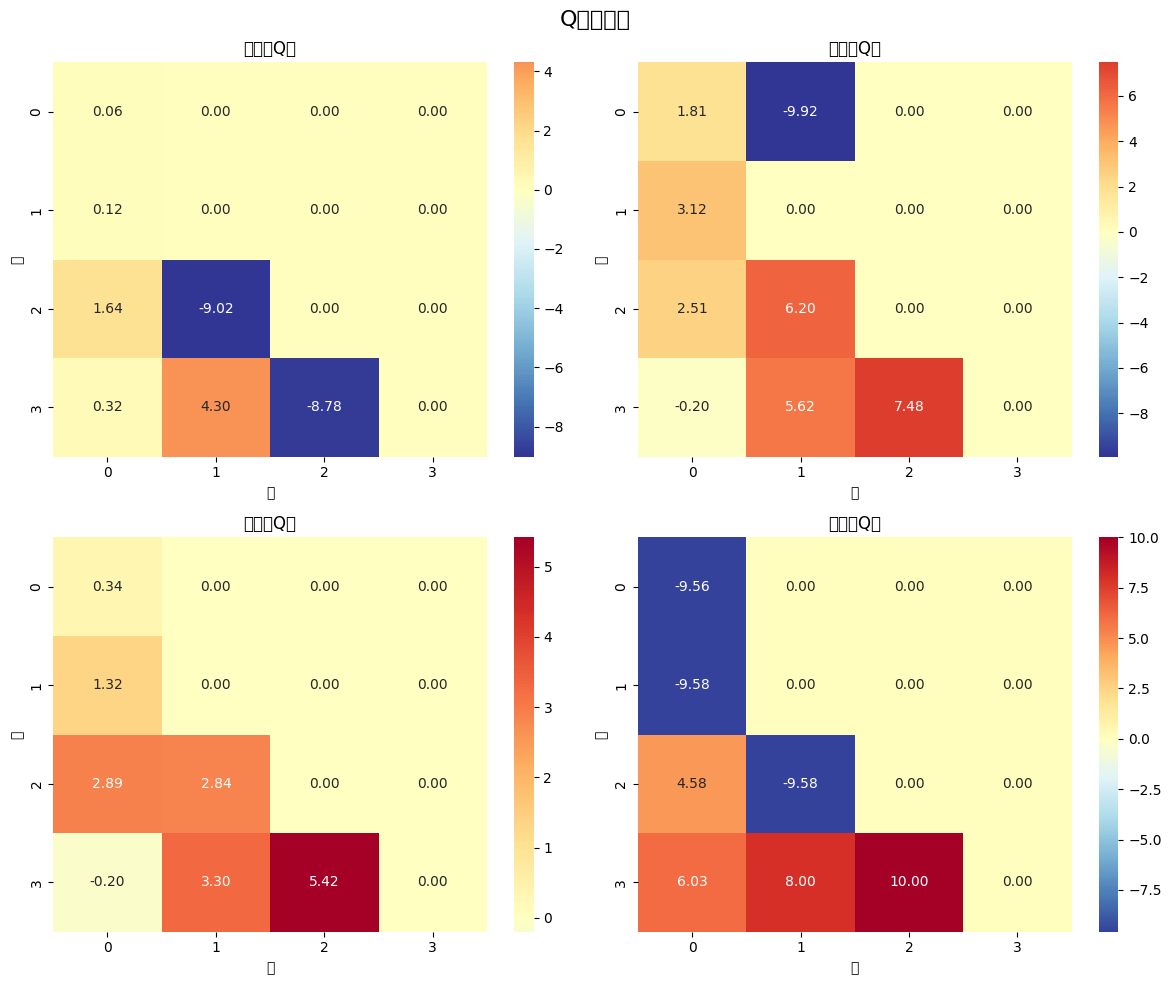

In [6]:
# 创建Q值热力图
def plot_q_values(q_table, env):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Q值热力图', fontsize=16)
    
    actions = ['up', 'down', 'left', 'right']
    action_names = ['上', '下', '左', '右']
    
    for idx, (action, name) in enumerate(zip(actions, action_names)):
        ax = axes[idx // 2, idx % 2]
        
        # 创建Q值矩阵
        q_matrix = np.zeros((env.rows, env.cols))
        
        for row in range(env.rows):
            for col in range(env.cols):
                state = (row, col)
                q_matrix[row, col] = q_table[state][action]
        
        # 绘制热力图
        sns.heatmap(q_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                   center=0, ax=ax, cbar=True)
        ax.set_title(f'{name}动作Q值')
        ax.set_xlabel('列')
        ax.set_ylabel('行')
    
    plt.tight_layout()
    plt.show()

# 绘制Q值热力图
plot_q_values(agent.q_table, env)

## 6. 测试训练好的智能体

In [7]:
def test_agent(env, agent, episodes=10):
    """测试训练好的智能体"""
    print("测试训练好的智能体:")
    
    for episode in range(episodes):
        state = env.reset()
        path = [state]
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < 50:
            # 使用最优策略（贪心策略）
            q_values = agent.q_table[state]
            if q_values:
                action = max(q_values, key=q_values.get)
            else:
                action = random.choice(env.actions)
            
            next_state, reward, done = env.step(action)
            
            path.append(next_state)
            total_reward += reward
            state = next_state
            steps += 1
        
        print(f"Episode {episode + 1}: Path = {path}, Reward = {total_reward}, Steps = {steps}")

# 测试智能体
test_agent(env, agent)

测试训练好的智能体:
Episode 1: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 2: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 3: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 4: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 5: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 6: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 7: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 8: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 9: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6
Episode 10: Path = [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3)], Reward = 5, Steps = 6


## 7. 动态ε衰减策略


开始训练带ε衰减的Q-learning智能体...
Episode 100, Epsilon: 0.606, Average Reward (last 100): -16.63
Episode 200, Epsilon: 0.367, Average Reward (last 100): -5.29
Episode 300, Epsilon: 0.222, Average Reward (last 100): -2.20
Episode 400, Epsilon: 0.135, Average Reward (last 100): -0.03
Episode 500, Epsilon: 0.082, Average Reward (last 100): 2.95
Episode 600, Epsilon: 0.049, Average Reward (last 100): 3.66
Episode 700, Epsilon: 0.030, Average Reward (last 100): 4.32
Episode 800, Epsilon: 0.018, Average Reward (last 100): 4.29
Episode 900, Epsilon: 0.011, Average Reward (last 100): 4.16
Episode 1000, Epsilon: 0.010, Average Reward (last 100): 4.95


/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/1764528351.py:72: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/1764528351.py:72: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/1764528351.py:72: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/1764528351.py:72: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgchq3kj0nvbgdvqn5fpgptw0000gp/T/ipykernel_11675/1764528351.py:72: UserWarning: Glyph 21169 (\N{CJK UNIFIED IDEOGRAPH-52B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/4_/xgch

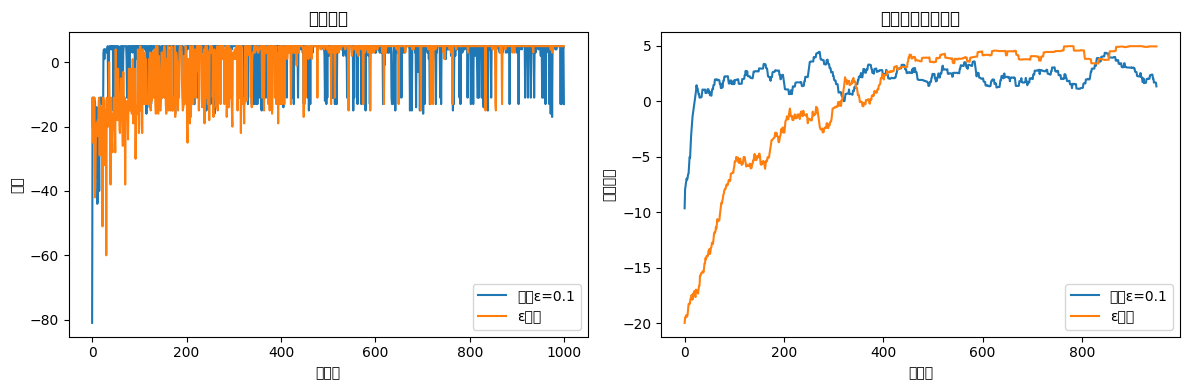

In [8]:
class QLearningAgentDecay(QLearningAgent):
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        super().__init__(env, learning_rate, discount_factor, epsilon)
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
    
    def decay_epsilon(self):
        """衰减ε值"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def train(self, episodes=1000):
        """训练Q-learning智能体，带ε衰减"""
        rewards_per_episode = []
        
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            
            while not done and steps < 100:
                action = self.get_action(state)
                next_state, reward, done = self.env.step(action)
                
                self.update_q_value(state, action, reward, next_state)
                
                state = next_state
                total_reward += reward
                steps += 1
            
            rewards_per_episode.append(total_reward)
            self.decay_epsilon()  # 衰减ε值
            
            # 每100个episode打印一次进度
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(rewards_per_episode[-100:])
                print(f"Episode {episode + 1}, Epsilon: {self.epsilon:.3f}, Average Reward (last 100): {avg_reward:.2f}")
        
        return rewards_per_episode

# 创建带ε衰减的智能体
agent_decay = QLearningAgentDecay(env, learning_rate=0.1, discount_factor=0.9, 
                                  epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)

# 训练
print("\n开始训练带ε衰减的Q-learning智能体...")
rewards_decay = agent_decay.train(episodes=1000)

# 比较两种方法
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards, label='固定ε=0.1')
plt.plot(rewards_decay, label='ε衰减')
plt.title('奖励对比')
plt.xlabel('回合数')
plt.ylabel('奖励')
plt.legend()

plt.subplot(1, 2, 2)
window_size = 50
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
moving_avg_decay = np.convolve(rewards_decay, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg, label='固定ε=0.1')
plt.plot(moving_avg_decay, label='ε衰减')
plt.title('移动平均奖励对比')
plt.xlabel('回合数')
plt.ylabel('平均奖励')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Q-learning算法总结

### 优点：
1. **无模型(model-free)**: 不需要知道环境的转移概率和奖励函数
2. **在线学习**: 可以实时更新Q值
3. **收敛保证**: 在适当条件下保证收敛到最优策略
4. **简单易实现**: 算法逻辑清晰，实现简单

### 缺点：
1. **状态空间限制**: 对于连续状态空间或大规模状态空间，Q表会变得非常大
2. **探索效率**: 需要足够的探索才能找到最优策略
3. **收敛速度**: 可能需要大量episode才能收敛

### 改进方法：
1. **ε衰减**: 逐渐减少探索率
2. **学习率衰减**: 逐渐减少学习率
3. **经验回放**: 存储和重用过去的经验
4. **函数逼近**: 使用神经网络替代Q表(如DQN)
5. **优先级经验回放**: 优先学习更重要的经验

## 应用场景

Q-learning适用于：
- 游戏AI（如Atari游戏）
- 机器人控制
- 推荐系统
- 资源调度
- 路径规划